In [1]:
# Adding the neccecary imports to our code
import matplotlib.pyplot as plt
import pandas as pd
import pydot # conda install pydot
import math
from data_structures import create_custom_graph,vertex_for_BFS,vertex_for_DFS,Stack,TreeVertex,RadialPoint

In [2]:
#type of data:
url_Les_Miserables_network  = '../data/LesMiserables.dot'
url_Rome_graph  = '../data/rome.dot'
url_Jazz_Network  = '../data/JazzNetwork.dot'
url_Small_Directed_Network  = '../data/noname.dot'
url_Pro_League_Network  = '../data/LeagueNetwork.dot'
url_Argumentation_network  = '../data/devonshiredebate_withclusters.dot'
url_Argumentation_network_for_part_five = '../data/devonshiredebate_withonlytwoclusters.dot'
url_Political_blogosphere_network  = '../data/polblogs.dot'


# BFS

In [3]:
def BFS(graph,root):
    #initializing the table for generating the graph
    tree_table = {}
    for vertex in graph.vertices.values():
        tree_table[vertex.id] = vertex_for_BFS(vertex.id)
    #initializing the queue for the visited vertices
    visited_vertices = []
    #Adjusting the root vertex
    visited_vertices.append(root)
    tree_table[root.id].color = 1
    tree_table[root.id].distance = 0

    while (visited_vertices != []):
        current_vertex = visited_vertices.pop(0)
        tree_table[current_vertex.id].color = 2
        for v in current_vertex.neighbors:
            if tree_table[v.id].color == 0:
                visited_vertices.append(v)
        for v in current_vertex.neighbors:
            if tree_table[v.id].color == 0:
                tree_table[v.id].color = 1
                tree_table[v.id].distance = (tree_table[current_vertex.id].distance + 1)
                tree_table[v.id].parent = current_vertex.id

    return tree_table



In [4]:
# Parsing the data from the dot file:
G = pydot.graph_from_dot_file(url_Les_Miserables_network)[0]
#Convering the graph into our custom graph
graph = create_custom_graph(G) #O(V) + O(E) = O(V + E)
tree_table = BFS(graph,graph.get_vertex('11'))
data = []
for key, obj in tree_table.items():
    data.append(vars(obj))  # Convert object attributes to dictionary
df = pd.DataFrame(data).sort_values(by='distance')
print(df)

    id  color  distance parent
10  11      2       0.0   None
24  33      2       1.0     11
25  34      2       1.0     11
26  35      2       1.0     11
27  36      2       1.0     11
..  ..    ...       ...    ...
4    5      0       inf   None
3    4      0       inf   None
2    3      0       inf   None
1    2      0       inf   None
0    1      0       inf   None

[77 rows x 4 columns]


# DFS

In [5]:
def DFS(graph,root):
    finished_vertex_count = 0
    vertices_stack = Stack()
    tree_table = {}
    n = len(graph.vertices)
    for vertex in graph.vertices.values():
        tree_table[vertex.id] = vertex_for_DFS(vertex.id)
    vertices_stack.push(root)
    tree_table[root.id].color=1
    tree_table[root.id].b= 1
    tree = DFS_recursive(graph,vertices_stack,n,0,tree_table,2)
    return tree
def DFS_recursive(graph, vertices_stack, n, finished_vertex_count, tree_table, time_stamp):
    if finished_vertex_count == n:
        return tree_table
    
    while not vertices_stack.is_empty():
        current_vertex = vertices_stack.top()
        found_unvisited_neighbor = False
        
        for v in current_vertex.neighbors:
            if tree_table[v.id].color == 0:
                found_unvisited_neighbor = True
                vertices_stack.push(v)
                tree_table[v.id].color = 1
                tree_table[v.id].b = time_stamp
                tree_table[v.id].parent = current_vertex.id
                time_stamp += 1
                break  # Break out of the loop to explore the new neighbor
        
        if not found_unvisited_neighbor:
            current_vertex = vertices_stack.pop()
            tree_table[current_vertex.id].color = 2
            tree_table[current_vertex.id].f = time_stamp
            finished_vertex_count += 1
            time_stamp += 1
            
    # If there are remaining unvisited vertices, continue the traversal
    remain_unvisited_vertex = [graph.get_vertex(vertex.id) for vertex in tree_table.values() if vertex.color == 0]
    if remain_unvisited_vertex:
        vertices_stack.push(remain_unvisited_vertex[0])
        tree_table[remain_unvisited_vertex[0].id].color = 1
        tree_table[remain_unvisited_vertex[0].id].b = time_stamp
        time_stamp += 1
    
    return DFS_recursive(graph, vertices_stack, n, finished_vertex_count, tree_table, time_stamp)

In [6]:
tree_table2 = DFS(graph,graph.get_vertex("11"))
data = []
for key, obj in tree_table2.items():
    data.append(vars(obj))  # Convert object attributes to dictionary
df = pd.DataFrame(data).sort_values(by='b')
print(df)

    id    b    f  color parent
10  11    1  134      2   None
11  12    2    3      2     11
12  13    4  125      2     11
16  24    5  124      2     13
44  17    6   19      2     24
..  ..  ...  ...    ...    ...
5    6  143  144      2      2
6    7  145  146      2      2
7    8  147  148      2      2
8    9  149  150      2      2
9   10  151  152      2      2

[77 rows x 5 columns]


# Radial Layout

In [17]:
def convert_to_tree(vertex_dict):
    vertex_map = {}  # Map vertex IDs to Treevertex instances
    root = None
    depth_cache = {}
    subtree_count_cache = {}

    # Step 1: Create Treevertex instances for each vertex
    for _, vertex in vertex_dict.items():
        if vertex.color != 2:
            continue
        vertex_map[vertex.id] = TreeVertex(vertex.id)

    # Step 2: Link Treevertex instances based on parent-child relationships
    for _, vertex in vertex_dict.items():
        if vertex.color != 2:
            continue
        parent_id = vertex.parent
        if parent_id is not None:
            vertex_map[vertex.id].parent = vertex_map[parent_id]
            vertex_map[parent_id].children.append(vertex_map[vertex.id])
        else:
            # If a vertex has no parent, it's the root of the tree
            root = vertex_map[vertex.id]
        depth_cache[vertex.id] = compute_depth(vertex_map[vertex.id])
    
    # Step 3: Compute subtree vertex count and store it in the subtree_count_cache
    for _, vertex in vertex_dict.items():
        if vertex.color != 2:
            continue
        subtree_count_cache[vertex.id] = subTree_vertex_count(vertex_map[vertex.id], subtree_count_cache)

    return root, depth_cache, subtree_count_cache
    
def compute_depth(vertex):
    depth = 0
    while vertex.parent:
        depth += 1
        vertex = vertex.parent
    return depth

def get_depth(vertex, depth_cache):
    if vertex.value in depth_cache:
        return depth_cache[vertex.value]
    return 0

def subTree_vertex_count(root, subtree_count_cache):
    if root.value in subtree_count_cache:
        return subtree_count_cache[root.value]

    queue = [root]
    count = 0
    while queue:
        current = queue.pop(0)
        count += 1
        for child in current.children:
            queue.append(child)
    subtree_count_cache[root.value] = count
    return count   

def get_subTree_count(root, subtree_count_cache):
    if root.value in subtree_count_cache:
        return subtree_count_cache[root.value]
        
def radial_positions(rooted_tree, vertex, alfa, beta, output_graph, depth_cache, subtree_count_cache):
    if vertex.parent is None:
        vertex.point = (0, 0)
        output_graph.append(RadialPoint(vertex, (0, 0), None))
    
    depth_of_vertex = get_depth(vertex, depth_cache)
    theta = alfa
    radius = 50 + (50 * depth_of_vertex)

    leaves_number = get_subTree_count(vertex, subtree_count_cache)
    for child in vertex.children:
        lambda_val = get_subTree_count(child, subtree_count_cache)

        mi = theta + (lambda_val / leaves_number * (beta - alfa))

        x = radius * math.cos((theta + mi) / 2.0)
        y = radius * math.sin((theta + mi) / 2.0)

        child.point = (x, y)

        output_graph.append(RadialPoint(child, (x, y), vertex.point))

        if child.children:
            radial_positions(rooted_tree, child, theta, mi, output_graph, depth_cache, subtree_count_cache)
        theta = mi
        
def visualize_radial_layout(ax, table, title):
    keys_to_remove = []
    f_value_of_root = None
    # Find the f value of the item with b value of 1
    for key, obj in table.items():
        if hasattr(obj, 'f') and obj.b == 1:
            f_value_of_root = obj.f
            break
    # If f_value_of_root is still None, there is no item with b value of 1
    if f_value_of_root is not None:
        # Find keys to remove
        keys_to_remove = [key for key, obj in table.items() if obj.f > f_value_of_root]
    
    # Remove the keys from the dictionary
    for key in keys_to_remove:
        table.pop(key, None)
        
    root_vertex, depth_cache, subtree_count_cache = convert_to_tree(table)
    output_graph = []
    radial_positions(root_vertex, root_vertex, 0, math.pi * 2, output_graph, depth_cache, subtree_count_cache)

    max_depth = max(depth_cache.values())
    for depth in range(1, max_depth + 1):
        vertices_on_layer = [vertex for vertex, d in depth_cache.items() if d == depth]
        if not vertices_on_layer:
            continue
        radius = 50 * depth
        circle = plt.Circle((0, 0), radius, color='gray', fill=False)
        ax.add_patch(circle)
        for point in output_graph:
            if depth_cache[point.vertex.value] == depth:
                x, y = point.point
                px, py = point.parent_point or (0, 0)  # Parent point or (0, 0) if root
                ax.plot([px, x], [py, y], 'k-')  # Draw edge
                ax.plot(x, y, 'bo')  # Draw vertex
                ax.text(x, y, point.vertex.value, fontsize=12, ha='center', va='bottom', color="green")
    
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title, fontsize=30)
    ax.axis('off')

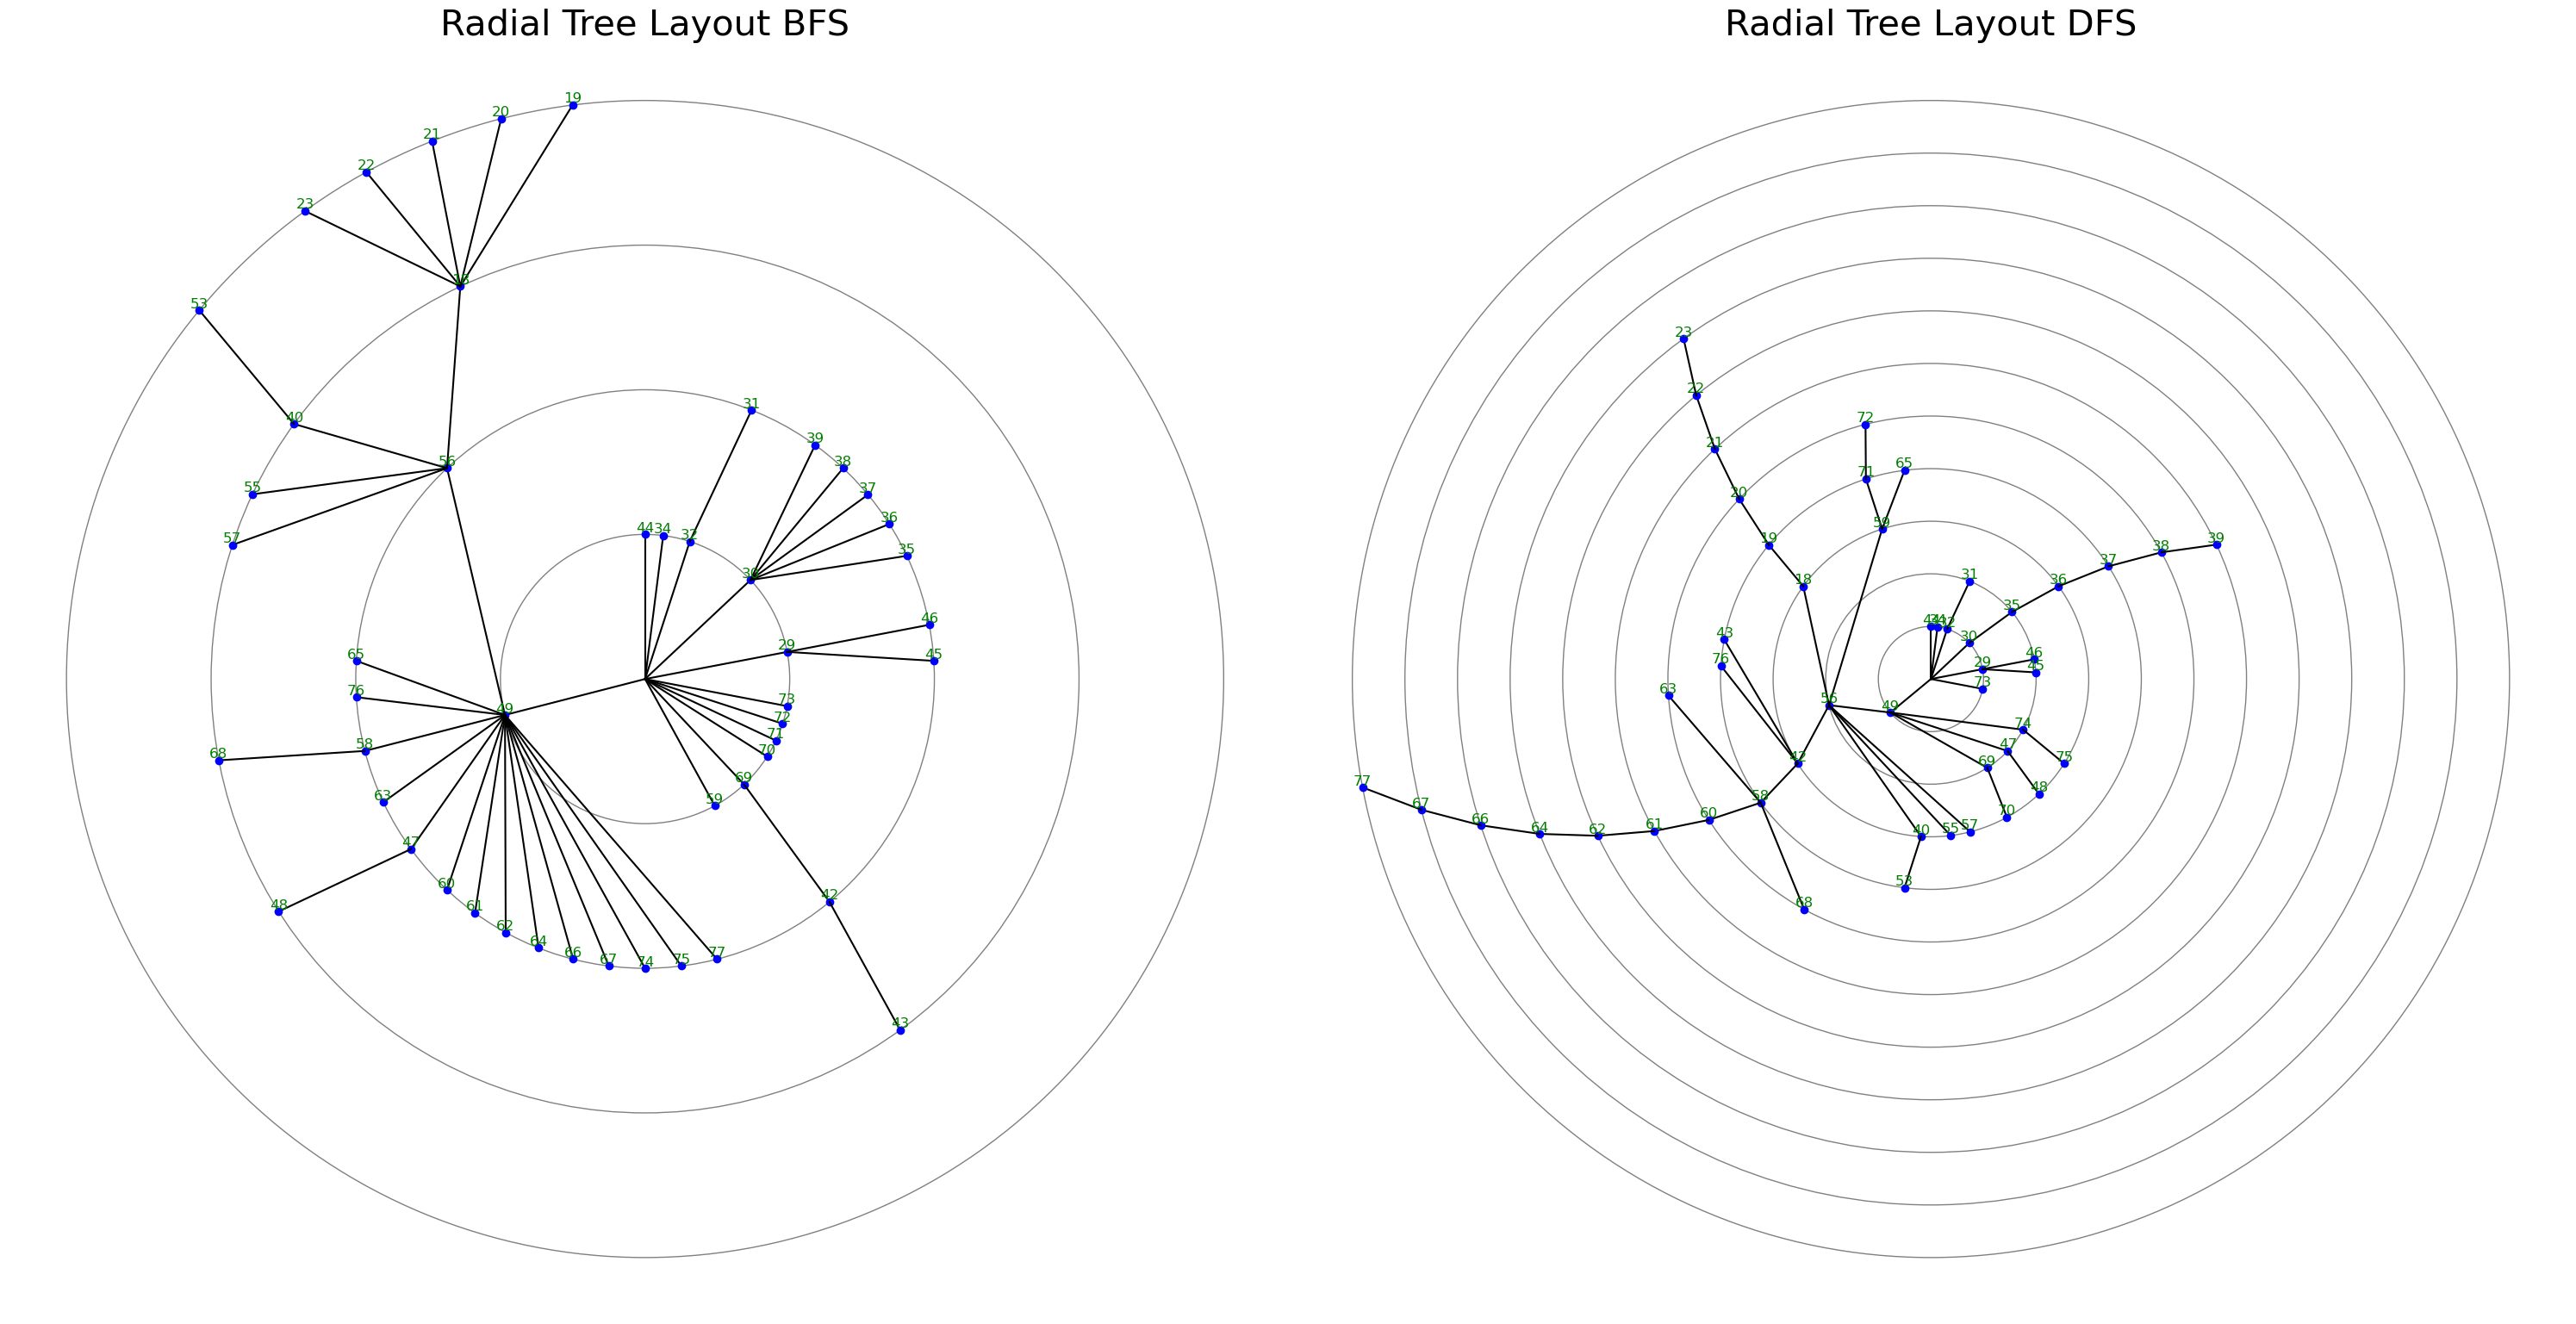

In [18]:
G=pydot.graph_from_dot_file(url_Les_Miserables_network)[0]
graph = create_custom_graph(G)

BFS_table = BFS(graph,graph.get_vertex("28"))
DFS_table = DFS(graph,graph.get_vertex("28"))

fig,axs = plt.subplots(1,2,figsize=(30,30))
visualize_radial_layout(axs[0],BFS_table,'Radial Tree Layout BFS')
visualize_radial_layout(axs[1],DFS_table,'Radial Tree Layout DFS')
plt.tight_layout()
plt.show()

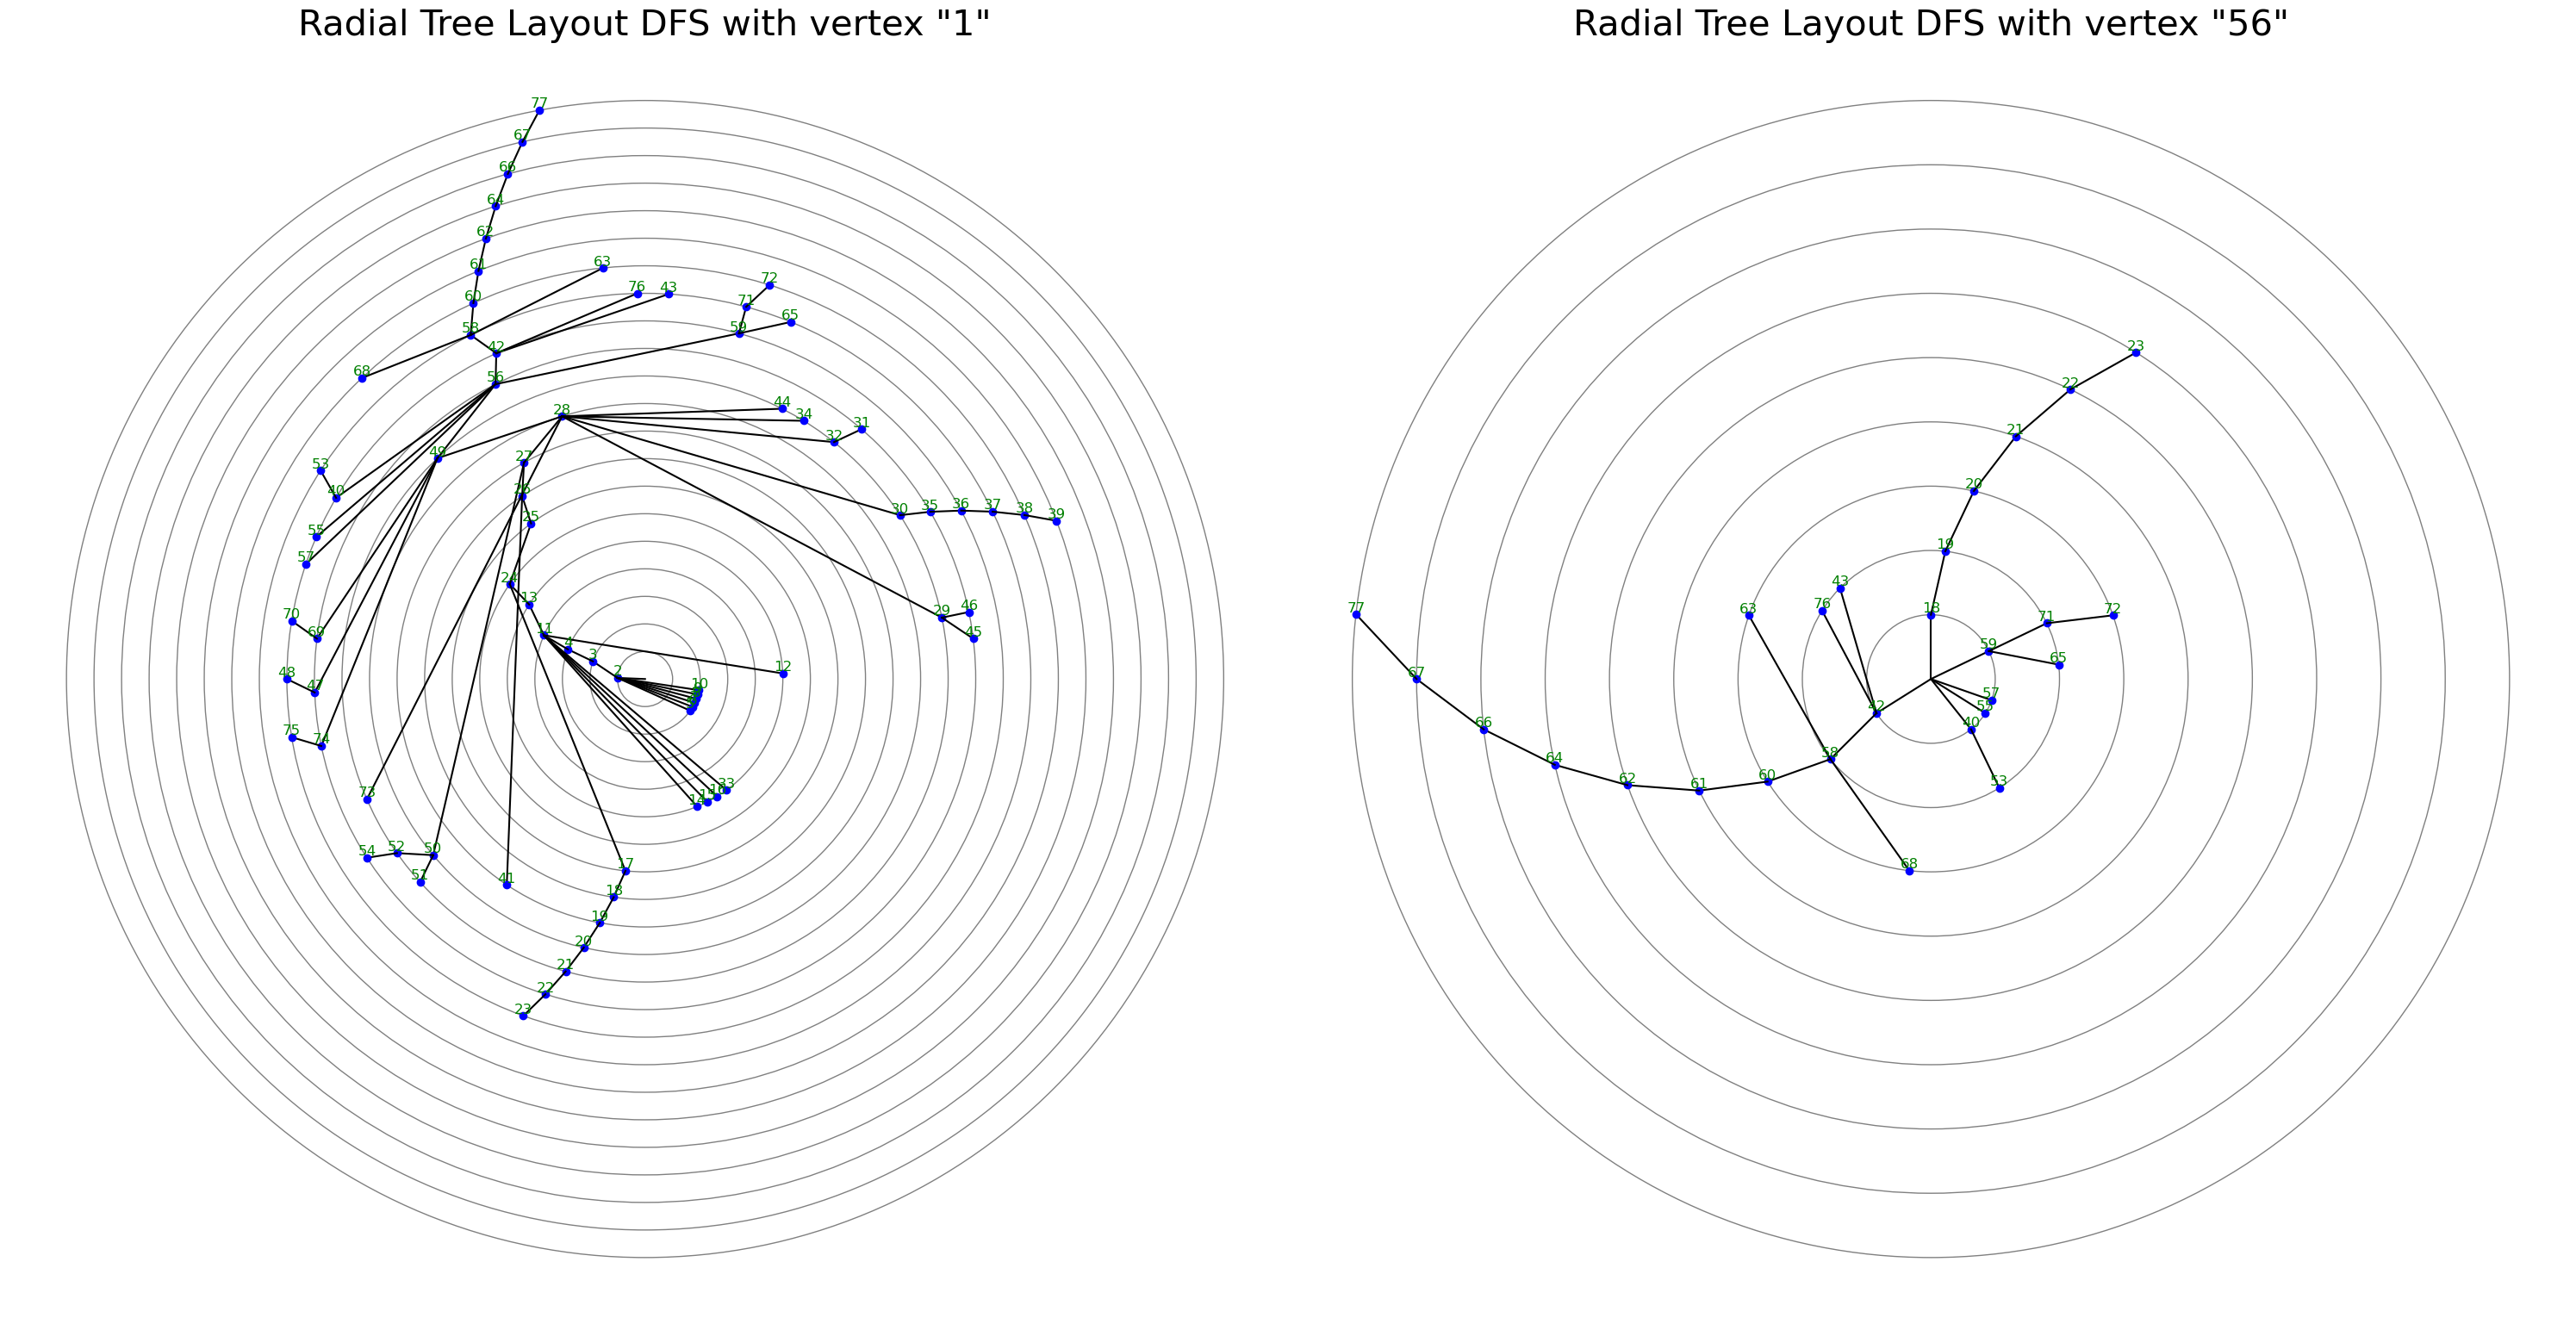

In [19]:
G=pydot.graph_from_dot_file(url_Les_Miserables_network)[0]
graph = create_custom_graph(G)

BFS_table = DFS(graph,graph.get_vertex("1"))
DFS_table = DFS(graph,graph.get_vertex("56"))

fig,axs = plt.subplots(1,2,figsize=(30,30))
visualize_radial_layout(axs[0],BFS_table,'Radial Tree Layout DFS with vertex "1"')
visualize_radial_layout(axs[1],DFS_table,'Radial Tree Layout DFS with vertex "56"')
plt.tight_layout()
plt.show()


In [20]:
def visualize_radial_layout_with_non_tree_edges(ax, table, non_tree_edges, title):
    # Convert table data into a tree structure
    root_vertex, depth_cache, subtree_count_cache = convert_to_tree(table)

    # Compute radial positions for tree vertices
    output_graph = []
    radial_positions(root_vertex, root_vertex, 0, math.pi * 2, output_graph, depth_cache, subtree_count_cache)

    # Visualize the tree with circles representing layers
    for point in output_graph:
        x, y = point.point
        px, py = point.parent_point or (0, 0)  # Parent point or (0, 0) if root
        ax.plot([px, x], [py, y], 'k-')  # Draw tree edge
        ax.plot(x, y, 'bo')  # Draw tree vertex
        ax.text(x, y, point.vertex.value, fontsize=12, ha='center', va='bottom', color="green")

    # Draw circles representing layers
    max_depth = max(depth_cache.values())
    for depth in range(1, max_depth + 1):
        vertices_on_layer = [vertex for vertex, d in depth_cache.items() if d == depth]
        if not vertices_on_layer:
            continue
        radius = 50 * depth
        circle = plt.Circle((0, 0), radius, color='gray', fill=False)
        ax.add_patch(circle)
    
    # Plot non-tree edges
    for edge in non_tree_edges:
        u = edge.start
        v = edge.end
        u_coords = None
        v_coords = None
        for point in output_graph:
            if u.id == point.vertex.value:
                u_coords = point.point
            elif v.id == point.vertex.value:
                v_coords = point.point
        if u_coords is not None and v_coords is not None:
            ax.plot([u_coords[0], v_coords[0]], [u_coords[1], v_coords[1]], 'r--')  # Draw non-tree edge

    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title, fontsize=30)
    ax.axis('off')

In [21]:
def create_non_tree_edges_list(G,tree_table):
    non_tree_edges =[]
    for edge in G.edges:
        if tree_table[edge.end.id].parent == edge.start.id:
            continue
        else:
            non_tree_edges.append(edge)
    return non_tree_edges


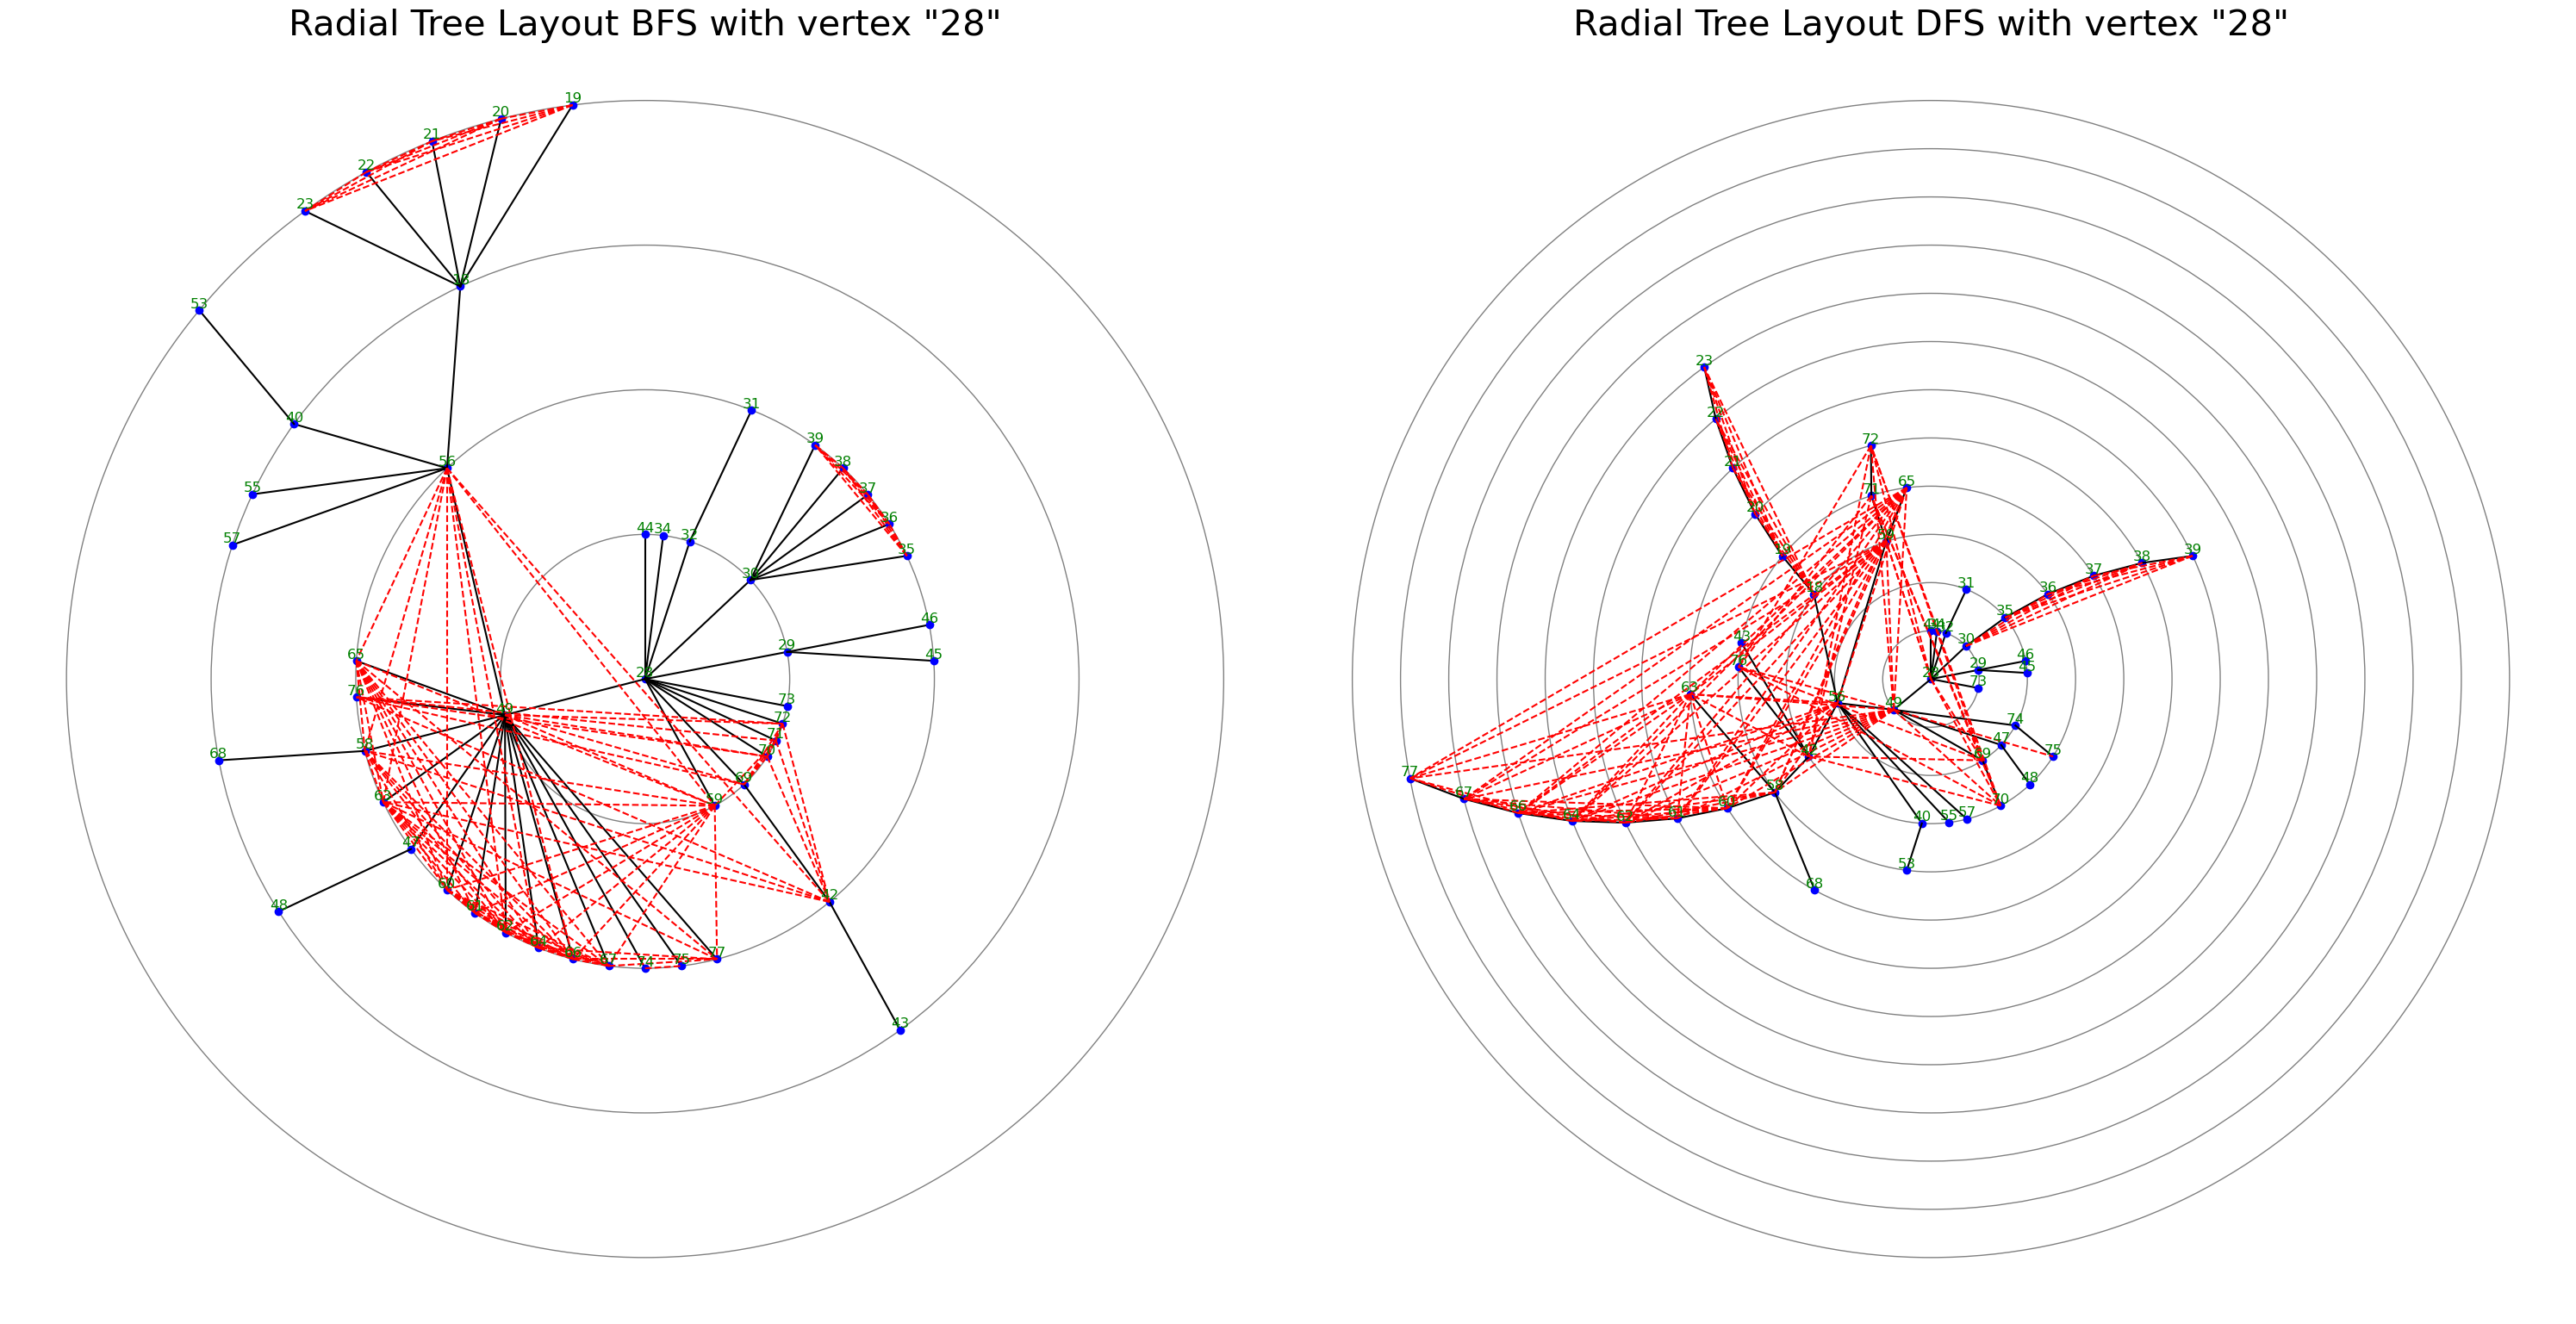

In [22]:
G=pydot.graph_from_dot_file(url_Les_Miserables_network)[0]
graph = create_custom_graph(G)

BFS_table = BFS(graph,graph.get_vertex("28"))
non_tree_list_BFS = create_non_tree_edges_list(graph,BFS_table)
DFS_table = DFS(graph,graph.get_vertex("28"))
non_tree_list_DFS = create_non_tree_edges_list(graph,DFS_table)
fig,axs = plt.subplots(1,2,figsize=(30,30))
visualize_radial_layout_with_non_tree_edges(axs[0],BFS_table,non_tree_list_BFS,'Radial Tree Layout BFS with vertex "28"')
visualize_radial_layout_with_non_tree_edges(axs[1],DFS_table,non_tree_list_DFS,'Radial Tree Layout DFS with vertex "28"')
plt.tight_layout()
plt.show()